In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
X, y = mnist["data"], mnist["target"]
X = X.to_numpy()
y = y.to_numpy()

In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [67]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
some_digit = X[0]


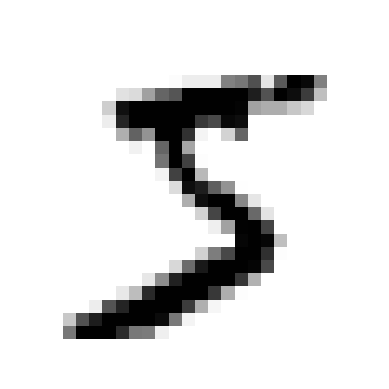

In [68]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [69]:
y[0]

'5'

In [70]:
y = y.astype(np.uint8)

In [71]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [72]:
y_train_5 = (y_train == 5) # True for all 5s, False
y_test_5 = (y_test == 5)

In [73]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [74]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [75]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [76]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [77]:
never_5_clf = Never5Classifier()

In [78]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

## Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix.

In [79]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [80]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [81]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection

In [82]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [83]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [84]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

In [85]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

## Precision/Recall Tradeoff

SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

In [86]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.

In [87]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the cross_val_predict() function
again, but this time specifying that you want it to return decision scores instead of
predictions:

In [88]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [89]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision and recall as functions of the threshold value using
Matplotlib

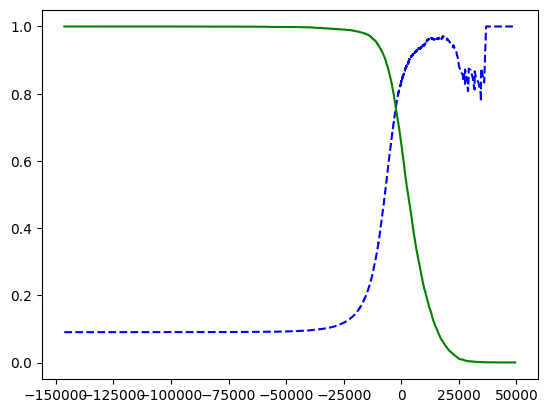

In [90]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [91]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [92]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [93]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [94]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

If someone says “let’s reach 99% precision,” you should ask, “at
what recall?”

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [95]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

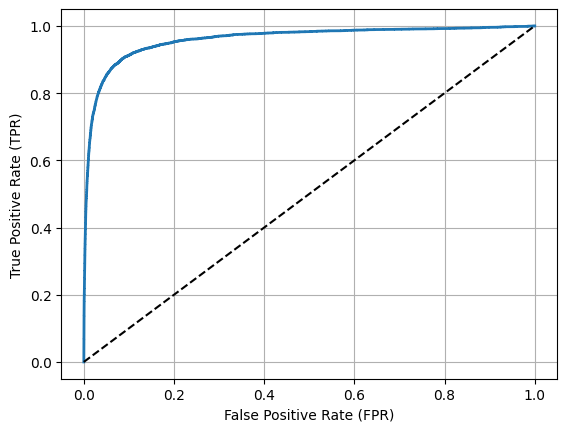

In [99]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [101]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [105]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score:

In [106]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

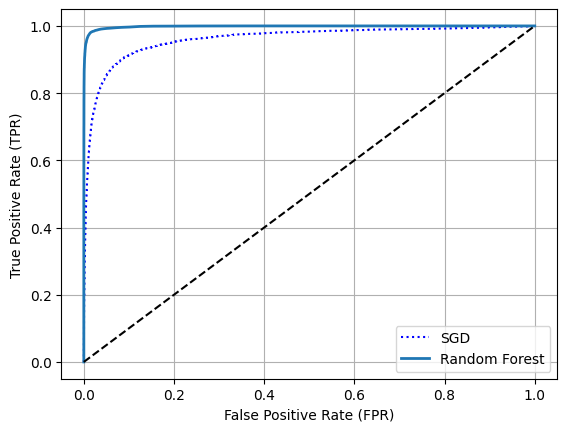

In [107]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [108]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.
To see that this is indeed the case, you can call the decision_function() method.
Instead of returning just one score per instance, it now returns 10 scores, one per
class:

# Multiclass Classification
Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes. Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
capable of handling multiple classes directly. Others (such as Support Vector Machine
classifiers or Linear classifiers) are strictly binary classifiers.

In [109]:
sgd_clf.fit(X_train, y_train)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [111]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.
To see that this is indeed the case, you can call the decision_function() method.
Instead of returning just one score per instance, it now returns 10 scores, one per
class:

In [113]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [114]:
np.argmax(some_digit_scores)

np.int64(3)

In [115]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [118]:
sgd_clf.classes_[3]

np.uint8(3)

When a classifier is trained, it stores the list of target classes in its
classes_  attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky.

# Error Analysis